**Name:** Luk Wing San (20193803), Gao Shenlai(20256746), Cheung Tin Yan (20197342)

**Math 4432: Project 1 Report Summary**

**Problem chosen:** Problem 3.  Bi-Classification: Switch unsafe wells

**Question proposed:** Are there any relationships between unsafe wells, amount of arsenic pollution, distance between the well from the nearest living area, education , community , X and Y?

**Goal:** Build a prediction model with high accuracy for switching unsafe wells

**Contributions:** Luk Wing San 1/3, Gao Shenlai 1/3, Timothy Cheung 1/3



#### Import libraries

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import itertools

%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Load data file, visualize the data and do some preprocessing

In [2]:
df = pd.read_csv('wells.csv')
df.head()

,switch,arsenic,unsafe,distance,x,y,community,education
0,True,236,True,1682.600021,260867.531250,2632851.25,0,0
1,True,71,True,4732.199860,260817.375000,2632870.25,0,0
2,False,207,True,2096.699905,260873.781250,2632848.75,0,10
3,True,115,True,2148.600006,260833.000000,2632839.00,0,12
4,True,196,True,3258.200073,260858.328125,2632808.50,1,12


First, we extract some data from the original dataset. The above data shows some of the original dataset from “wells.csv”.
Then, we do a quick summary for the information, which is shown below. We have found that community and education may be categorical predictors, but we treat them as real-valued predictors here first.

In [3]:
print(df.info())
print(df.describe())
# base on the values shown by df.head() and the information here,
# we may find that community and education are categorical predictors
# however, here we firstly used them as real-value predictors
# they will be converted as dummy variables in later part

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 8 columns):
switch       6448 non-null bool
arsenic      6448 non-null int64
unsafe       6448 non-null bool
distance     6448 non-null float64
x            6448 non-null float64
y            6448 non-null float64
community    6448 non-null int64
education    6448 non-null int64
dtypes: bool(2), float64(3), int64(3)
memory usage: 314.9 KB
None
           arsenic      distance              x             y    community  \
count  6448.000000   6448.000000    6448.000000  6.448000e+03  6448.000000   
mean     95.188275   3165.042663  257674.824817  2.632179e+06     0.465571   
std     111.630471   3379.930532    1816.886614  1.335963e+03     0.660475   
min       1.000000      3.400000  253669.984375  2.629010e+06     0.000000   
25%       9.000000    937.424994  256361.308594  2.631209e+06     0.000000   
50%      56.000000   1961.000061  257526.226562  2.632346e+06     0.000000   
75%     136.00

In [4]:
df['unsafe01'] = [1 if el == True else 0 for el in df.unsafe]
# as the unsafe is a bool predictor with value True and False,
# which can result in error in fitting using sm.logit, we convert it to 1 and 0 as a real-valued predictor

The graph below is a big picture showing coorelation between each different predictors. We have found that X and Y are highly correlated by this graph visually. Howvever, there seems to be no significant correlation between other predictors on the graph below.

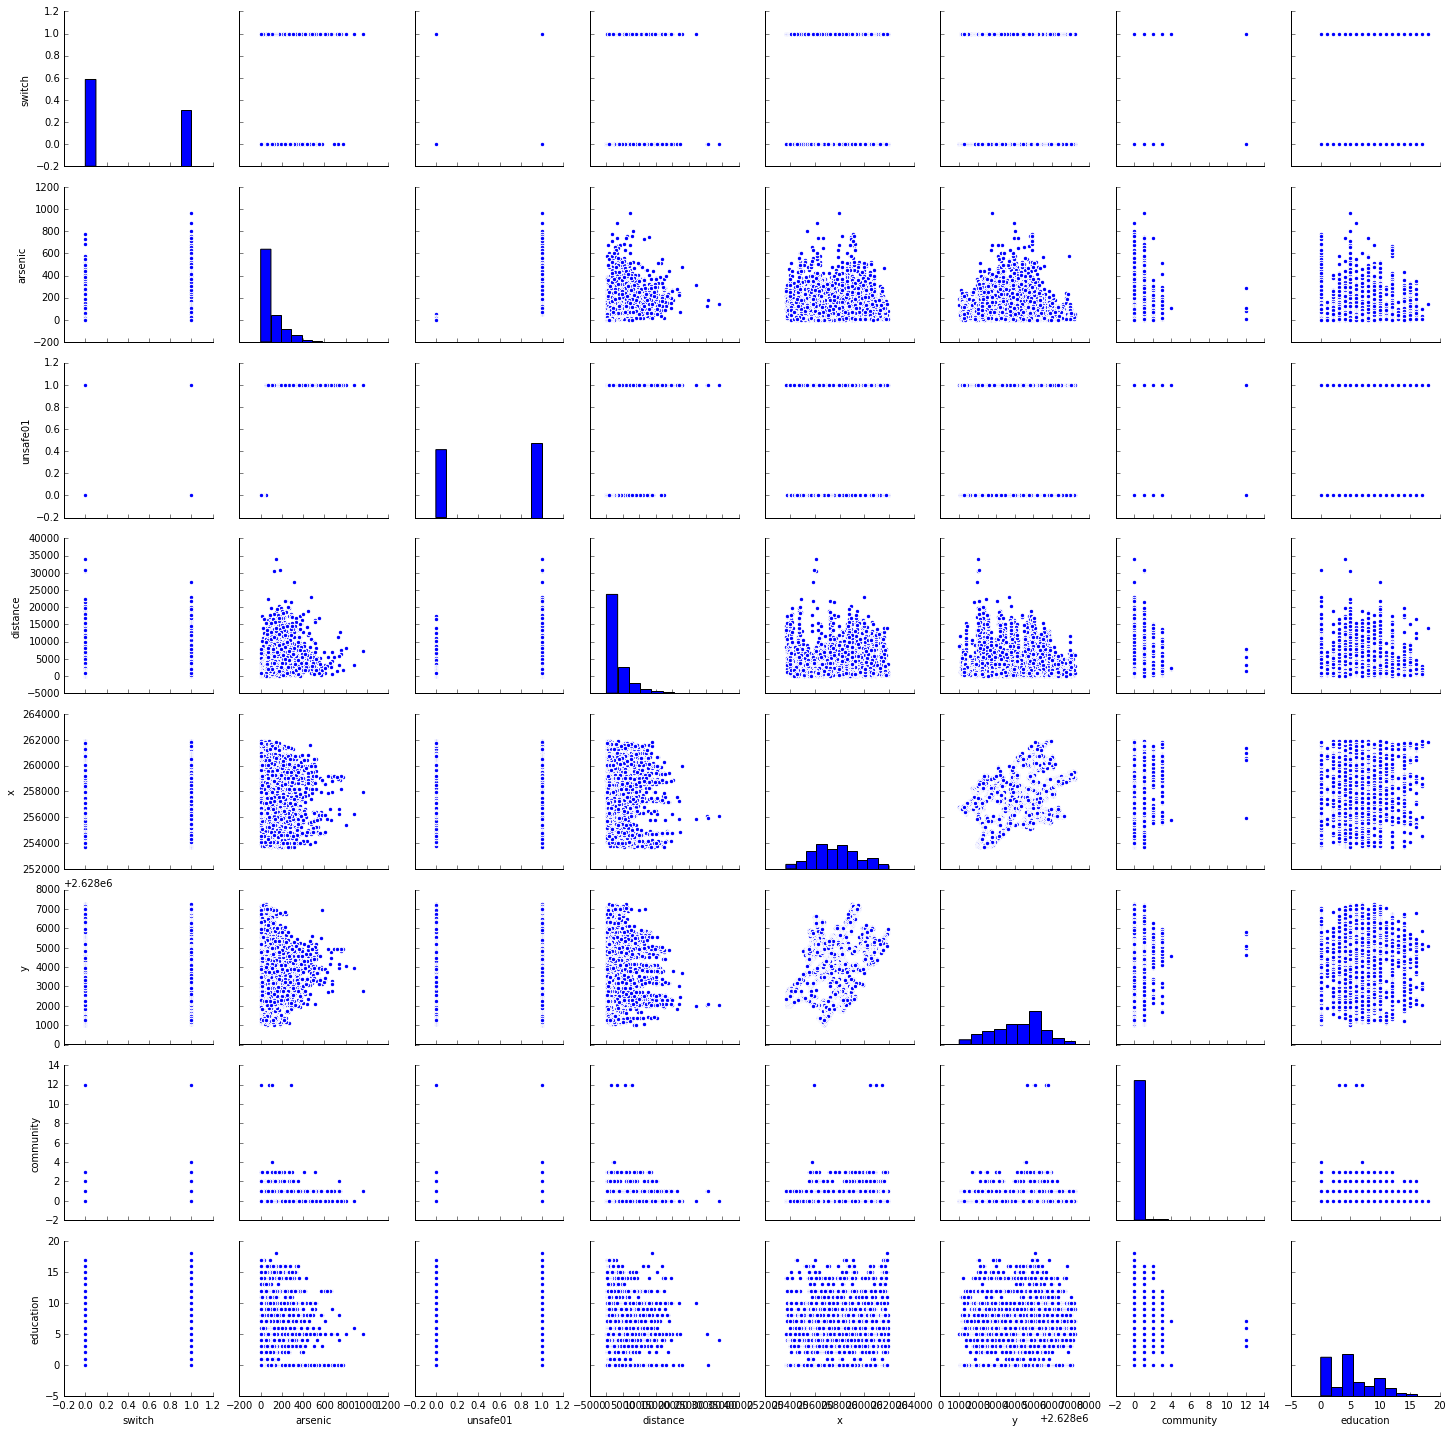

In [5]:
sns.pairplot(df[['switch','arsenic','unsafe01','distance','x','y','community','education']]);
# pair plot, we can see 'x' and 'y' and pretty correlated, though we may not find other useful information here

The below coding is a data preprocessing step to help normalize all the data values to become between 0 and 1 in order to increase the accuracy of our models. It is because some of the data in our predictors are too large, which may affect the accuracy. After normalizing the data values, we extract some data from our normalized dataset and show them below. We also plot a big graph showing correlation between predictors again below.

In [6]:
# normalize the data[column_name] to be in [min_v, max_v], defaultly [-1, 1]
def normalize (data, column_name, max_v=1, min_v=-1):
    max_value=data[column_name].max()
    min_value=data[column_name].min()
    data[column_name] = [((value-min_value) / (max_value-min_value)) * (max_v-min_v)+min_v for value in data[column_name]]
# regard values outside the range [mean-2*std, mean+2*std] as outliners and remove the record
def reject_outliers(data, column_name, m=2):
    return data[abs(data[column_name] - np.mean(data[column_name])) < m * np.std(data[column_name])]
# switch	arsenic	unsafe	distance	x	y	community	education

# remove outliners for arsenic, distance, x, and y (real-valued features)
df=reject_outliers(df, 'arsenic')
df=reject_outliers(df, 'distance')
df=reject_outliers(df, 'x')
df=reject_outliers(df, 'y')
# normalize them in range [0, 1]
normalize(df, 'arsenic', 1, 0)
normalize(df, 'distance', 1, 0)
normalize(df, 'x', 1, 0)
normalize(df, 'y', 1, 0)
normalize(df, 'unsafe01', 1, 0)
normalize(df, 'education', 1, 0)

print(df.shape)
df.head()
# the records number decrease from 6XXX to 5XXX

(5263, 9)


,switch,arsenic,unsafe,distance,x,y,community,education,unsafe01
0,True,0.741325,True,0.175956,0.978926,0.617425,0,0.000000,1.0
1,True,0.220820,True,0.495510,0.971661,0.620920,0,0.000000,1.0
2,False,0.649842,True,0.219348,0.979831,0.616966,0,0.588235,1.0
3,True,0.359621,True,0.224786,0.973924,0.615172,0,0.705882,1.0
4,True,0.615142,True,0.341056,0.977593,0.609563,1,0.705882,1.0


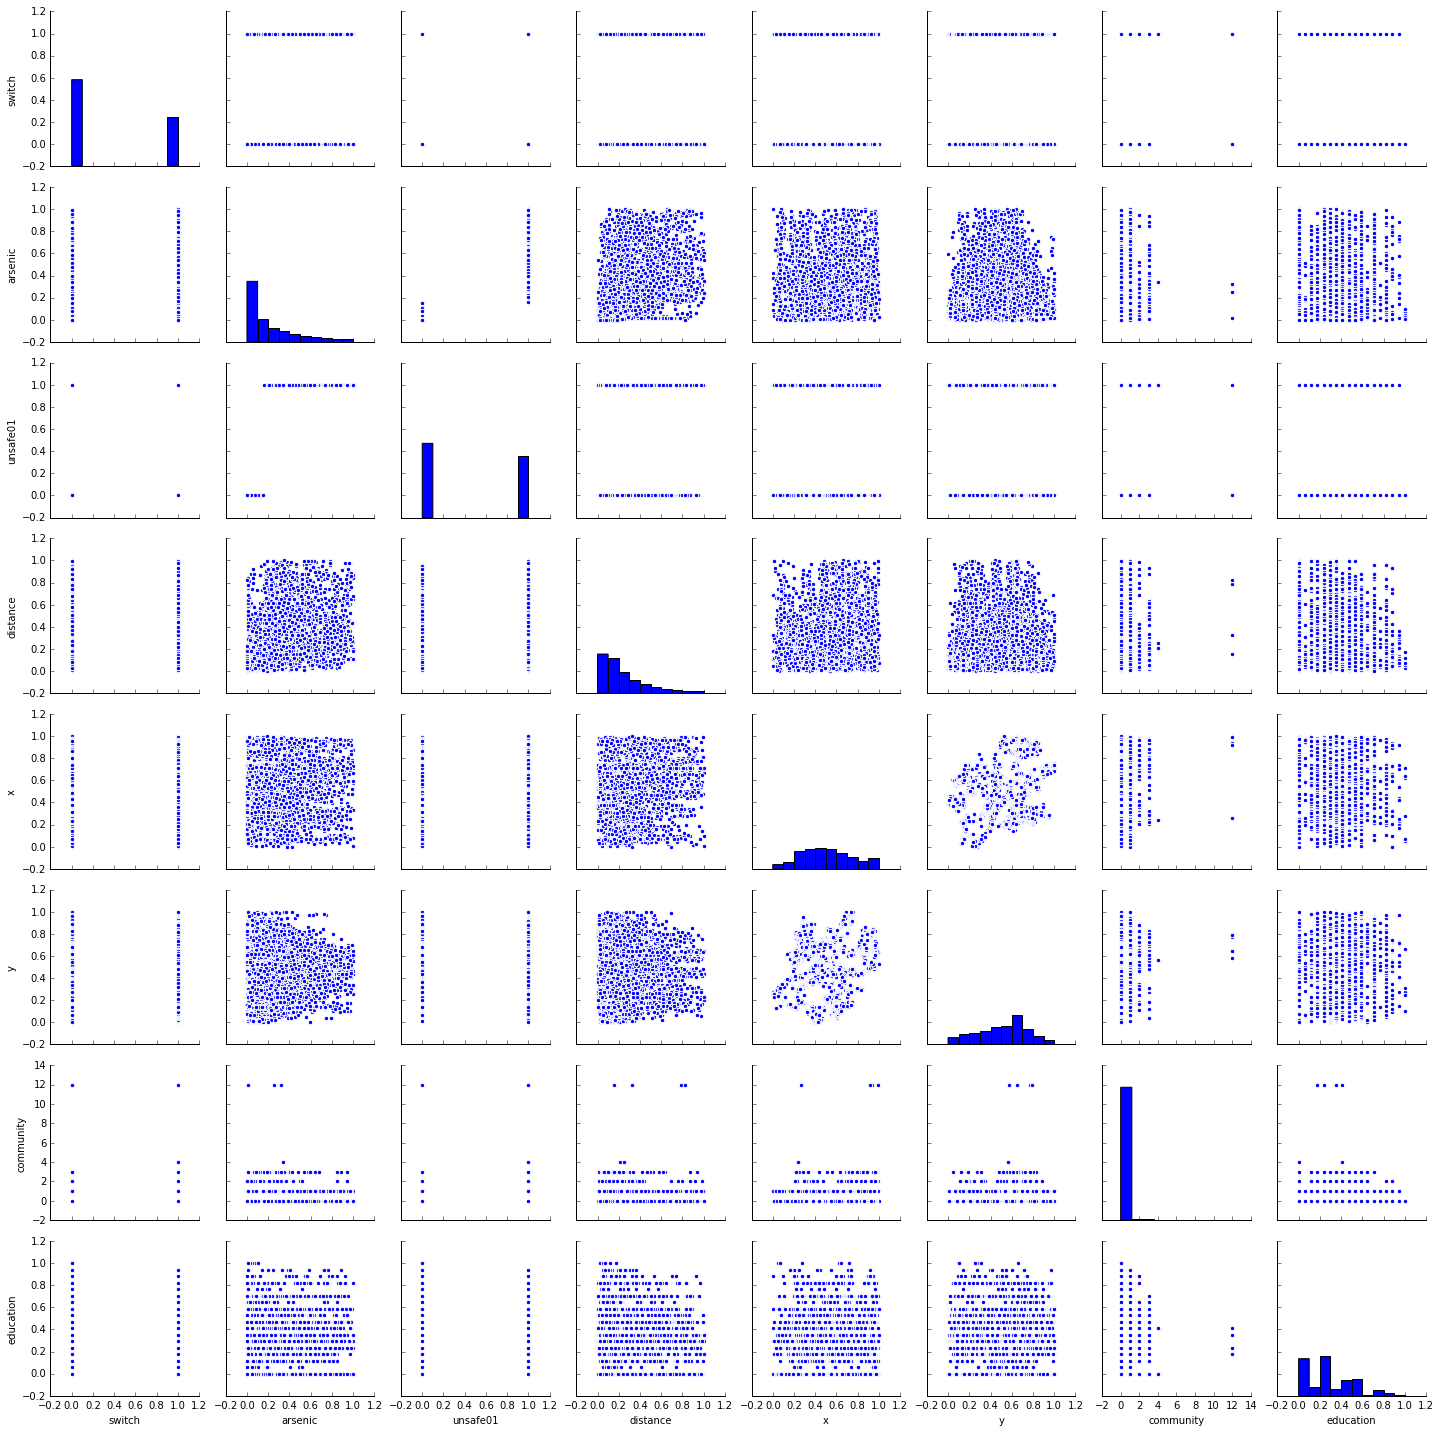

In [7]:
sns.pairplot(df[['switch','arsenic','unsafe01','distance','x','y','community','education']]);

#### helper functions

Below are a list of functions we have defined to help us to build our model. We have defined functions for doing brute-force searching of different comination of predictors. Then, we find out the model with combination of predictors which give the highest accuracy. We have also defined a boostrap function for resampling, a function for computing mean, standard deviation and information from data generated by boostrap and a confusion matrix function  which plot the confusionmatriz graph with accuracy (classification error), specificity, sentivity,recall and prediction rate (type I and type II error). An uncertainty function is also defined to help visualize the mean, sd and confidence interval. A function for plotting the ROC curve with Area-Under-Curve is also defined. Finally, we have made a function for doing k-fold cross validation. We mainly do the logistic regression by calling it from the sklearn library.


In [8]:
# generate a list of all combinations of input predictors for brute-force searching for best predictor combinations
# as there are only 7 features, only 2^7-1 = 127 models, so we can do it bruteforcelly
def getpredictorslist(features):
    predictors_list =[]
    for L in range(0, len(features)+1):
        for subset in itertools.combinations(features, L):
            if subset != ():
                ls = np.ndarray.tolist(np.array(subset))
                predictors_list.append(ls)
    return predictors_list

# the logistic regression model by calling the api
def logistic_regression(y, X):
    model = sm.Logit(y,X)
    return model.fit_regularized(disp=0, maxiter=1000)

# take sample from df data and train for models sample times
# collect all parameters 
def bootstrap (df, predictors, target, samples):
    coefficients = {}
    for key in predictors:
        coefficients[key] = []
    for i in range(0, samples):
        df_train = df.sample(frac=0.9, replace=True)

        X_train = df_train[predictors]
        y_train = df_train[target]
        
        results = logistic_regression(y_train, X_train)

        params = results.params
#         print('bootstrap', params)
        for key in predictors:
            coefficients[key].append(params[key])
    return coefficients

# compute information for the collected parameters array generated from bootstrap
# including mean, std, confidence interval provided confidence level
def process_as_distribution (coefficients, confidence):
    results = {}
    for key in coefficients.keys():
        array = coefficients[key]
        sortedArray = array[:]
        sortedArray.sort()
        startIndex=int(len(sortedArray)*(1.0-confidence)/2.0)
        results[key] = [
            np.mean(array),
            np.std(array),
            (sortedArray[startIndex], sortedArray[len(sortedArray)-1-startIndex], confidence)
        ]
    return results

# visualize data generated from bootstrap and process_as_distribution
# to visualize the uncertainty
def uncertainty (coefficients0, coefficients, confidence):
    distribute_info=process_as_distribution(coefficients, confidence)
    print('predictor : [value] [bootstrap mean, bootstrap std, (bootstrap confidence interval, confidence)]')
    for key in distribute_info.keys():
        print(key, ': ', coefficients0[key], distribute_info[key])
    for key in coefficients.keys():
        data_array = coefficients[key]
        weights = np.ones_like(data_array) / len(data_array)
        plt.hist(data_array, weights=weights, bins=20)
        plt.axvline(x=coefficients0[key], color='red')
        plt.axvline(x=distribute_info[key][2][0])
        plt.axvline(x=distribute_info[key][2][1])
        plt.title(key)
        plt.show()

# visualize the confusion matrix
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'False Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'True Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.4f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.4f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()

# generate roc curve and area under curve
# visualize them
def get_roc_and_area(predictions_test, outcome_test):
    fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# train a model, display the summary, confusion matrix, roc curve and area under curve
def prediction_and_display(predictors, df_train, df_test, logging=False, method=None):
    X_train = sm.add_constant(df_train[predictors])
    X_test = sm.add_constant(df_test[predictors])
    y_train = [1 if el else 0 for el in df_train.switch]
    y_test = [1 if el else 0 for el in df_test.switch]
    mol = logistic_regression(y_train, X_train)
    y_pred = [1 if el>=0.5 else 0 for el in mol.predict(X_test)]
    C = confusion_matrix(y_test, y_pred)
    accuracy = (C[1,1]+C[0,0])/(C[0,0]+C[0,1]+C[1,0]+C[1,1])
    if logging:
        print(mol.summary())
        show_confusion_matrix(C, ['No Switch', 'Switch'])
        get_roc_and_area(y_pred, y_test)
    return mol,accuracy

# do k_fold cross validation and return the mean square error and accuracy
def k_fold(df, predictors, threshold=0.5):
    X = df[predictors].values
    y = df['switch'].values
    kfold = KFold(n=len(df), n_folds=10)
    msearray = []
    accarray = []
    for train, test in kfold:
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
        model = logistic_regression(ytrain, Xtrain)
        ypred = model.predict(Xtest)
        msearray.append(mean_squared_error(ypred, ytest))
        accarray.append(np.mean((ypred > threshold) == ytest))
    return np.mean(msearray), np.mean(accarray)

#### logistic regression with all predictors and get z-values, p-values, misclassification error, confusion matrix, roc curve, uncertainty etc.

In [9]:
predictors = ['arsenic','unsafe01','distance','x','y','community','education']
np.random.seed(int(8))
rows = np.random.choice([True, False], int(len(df)*0.8))
df_train = df.loc[rows]
df_test = df.loc[~rows]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2084
Model:                          Logit   Df Residuals:                     2076
Method:                           MLE   Df Model:                            7
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                  0.2330
Time:                        18:03:14   Log-Likelihood:                -1057.2
converged:                       True   LL-Null:                       -1378.4
                                        LLR p-value:                1.768e-134
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0937      0.197    -10.612      0.000      -2.480      -1.707
arsenic        1.9353      0.344      5.627      0.000       1.261       2.609
unsafe01       1.8939      0.170     11.150      0.0

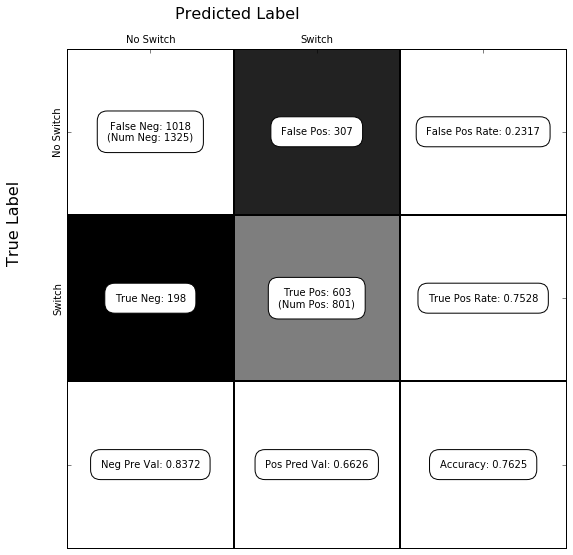

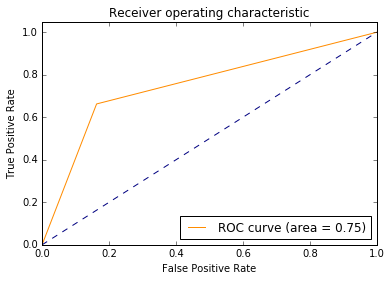

predictor : [value] [bootstrap mean, bootstrap std, (bootstrap confidence interval, confidence)]
arsenic :  1.9353427888779955 [1.811436618037633, 0.22739523378242735, (1.379661875824945, 2.2791991549157946, 0.95)]
unsafe01 :  1.8939108951249368 [1.6467520709839922, 0.11667357327543329, (1.4294381915268677, 1.8769210244846781, 0.95)]
distance :  -0.6420823961069323 [-1.3099284611532467, 0.18988185265575594, (-1.6845124930194555, -0.9446817266153418, 0.95)]
x :  -0.03905523841510673 [-1.0481543918043155, 0.14745206181418244, (-1.3418627803427798, -0.767798736615034, 0.95)]
y :  0.5261198726571212 [-1.0087457321893043, 0.11668909206179943, (-1.2321718492553546, -0.7885473316832403, 0.95)]
community :  -0.12221638316616058 [-0.18432051195078447, 0.06739814271105901, (-0.3156239641489397, -0.05231199178783939, 0.95)]
education :  0.3422799886128183 [-0.7791364352609059, 0.13997520551885376, (-1.0500711629593305, -0.5185553434146699, 0.95)]


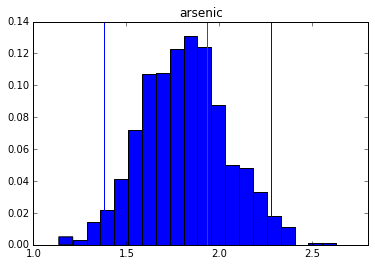

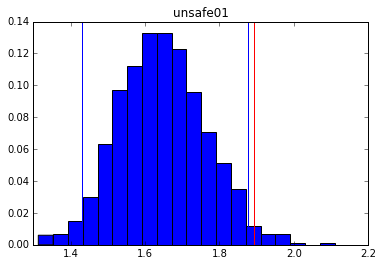

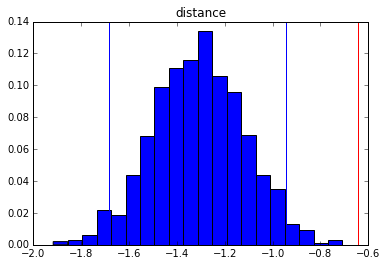

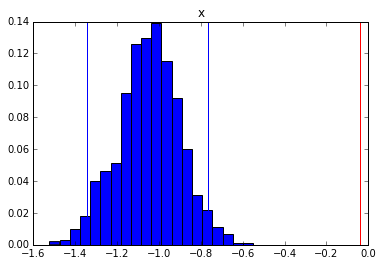

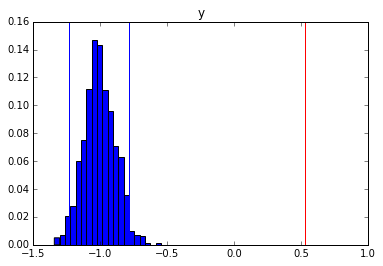

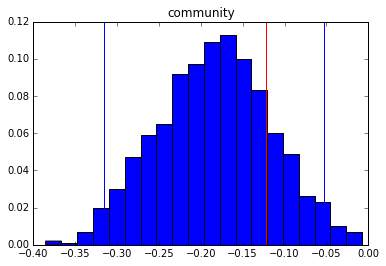

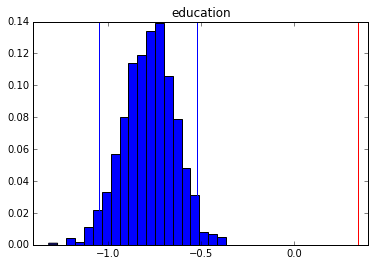

In [10]:
# train a model using all of the predictors
model0,accuracy0 = prediction_and_display(predictors, df_train, df_test, True)

coefficients=bootstrap(df, predictors, 'switch', 1000)
uncertainty(model0.params, coefficients, 0.95)

#### bruteforce all predictor combinations and choose favorite one by cross validation

The set of 127 predictor combinations is generated with all 7 predictors. We then plug each predictor combination to the logistic regression model and evaluate each with k-fold cross validation.

In the cross validation, each model would return the MSE and accuracy. We choose the best model that gives the lowest MSE after applying k-fold cross validation. If there are 2 models with the same MSE value, we would then use accuracy as the selection criterion.

To monitor the overall performance of the best model in comparison with other models generated, we also include the average MSE and accuracy of all models.

127 

Predictors:  ['arsenic', 'unsafe01', 'distance', 'x', 'y', 'community', 'education'] \mse:  0.1829427841516122 ccu:  0.7440624526518569
Avg. mse:  0.2060767130060397 Avg. accu:  0.6936314414565756


predictor : [value] [bootstrap mean, bootstrap std, (bootstrap confidence interval, confidence)]
arsenic :  [1.57933827529824] [1.8239375896676697, 0.2307473640708306, (1.38537709657199, 2.2752357748187926, 0.95)]
unsafe01 :  [1.5628940732168908] [1.650997844743691, 0.11031315796199932, (1.4350973880585014, 1.866554678543666, 0.95)]
distance :  [-1.0621237565739838] [-1.3139339479866248, 0.19096880329418667, (-1.6854186989912328, -0.9483026054588731, 0.95)]
x :  [-0.7028921255816334] [-1.052992914217529, 0.1431240473957182, (-1.3268044679629085, -0.7573505089435987, 0.95)]
y :  [-1.20932631348252] [-1.008390852096637, 0.11881922143830391, (-1.2491175896623847, -0.7748802840120287, 0.95)]
community :  [-0.23451985153038857] [-0.1829453989398375, 0.07000805382794924, (-0.32134372664510

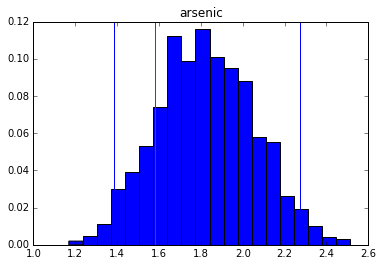

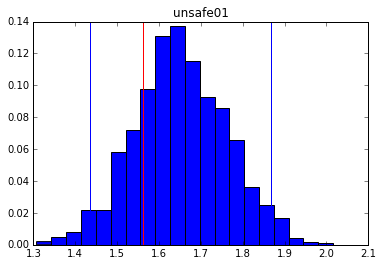

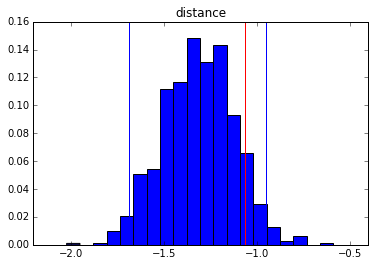

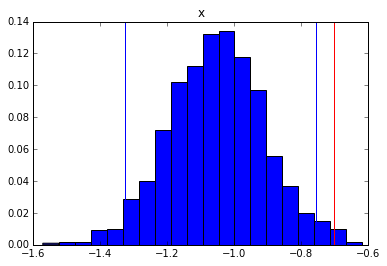

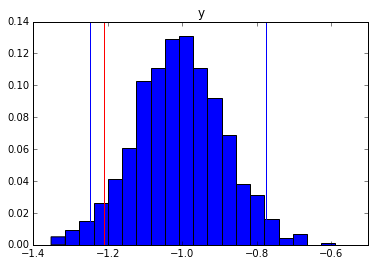

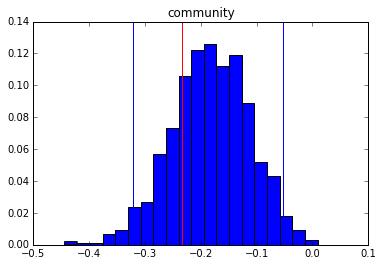

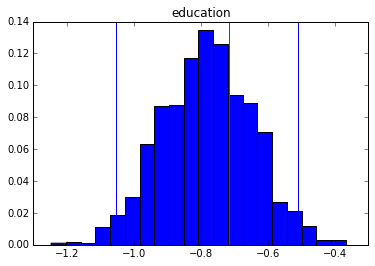

In [11]:
# choose the best predictors combinations by bruteforce search and k fold cross validation
predictors_new = ['arsenic','unsafe01','distance','x', 'y','community','education']
predictors_list = getpredictorslist(predictors_new)
print(len(predictors_list),'\n')
accuracy = []
mses = []
best_model = [None,float('inf'), 0]
# choose best model according to mean squared error and accuracy returned by k fold cross validation
for predictor in predictors_list:
    mse, accu = k_fold(df, predictor)
    accuracy.append(accu)
    mses.append(mse)
    if mse < best_model[1]:
        best_model = [predictor, mse, accu]
    else:
        if mse == best_model[1]:
            if accu > best_model[2]:
                best_model = [predictor, mse, accu]
print('Predictors: ',best_model[0],'\mse: ',best_model[1], '\accu: ',best_model[2])
print('Avg. mse: ', np.mean(mses), 'Avg. accu: ', np.mean(accuracy))
print('\n')

# measure and visualize the uncertainty of the model using the best combination of predictors
predictors=best_model[0]
model_params=bootstrap(df, predictors, 'switch', 1)
coefficients=bootstrap(df, predictors, 'switch', 1000)
uncertainty(model_params, coefficients, 0.95)


After we have selected the one predictor combination that gives us the best model, we then make use of bootstrap to measure the uncertainty of the model and visualise each predictor with graphs.

The histograms show the collected parameters generated from bootstrap as a distribution. The red line is a sample of the parameters and the two blue lines are the 0.95 confidence interval for the distribution. 
As some of the red line is not very close to the center of the distribution and some of the red lines go out of the 0.95 confidence interval, hence, the model may not be very stable. 

### treat education and community as categorical predictor 

#### read data and do preprocessing

Previously, we treated <i>education</i> and <i>community</i> as scaler predictors. But in reality, these two predictors are most likely to be categorical. So we would like to see if the preformance of the model would improve, by treating <i>education</i> and <i>community</i> differently.

In other words, we create boolean variables for each different value for these two predictors. And the original <i>education</i> and <i>community</i> columns are treated as dummy variables now.

In [12]:
df = pd.read_csv('wells.csv')
df['unsafe01'] = [1 if el == True else 0 for el in df.unsafe]
def normalize (data, column_name, max_v=1, min_v=-1):
    max_value=data[column_name].max()
    min_value=data[column_name].min()
    data[column_name] = [((value-min_value) / (max_value-min_value)) * (max_v-min_v)+min_v for value in data[column_name]]
def reject_outliers(data, column_name, m=3):
    return data[abs(data[column_name] - np.mean(data[column_name])) < m * np.std(data[column_name])]
# switch	arsenic	unsafe	distance	x	y	community	education

pd_dummies = pd.get_dummies( df, columns = ['education', 'community'] )
pd_dummies.head()
# make education and community dummy variables as we treat them as categorical predictors now

,switch,arsenic,unsafe,distance,x,y,unsafe01,education_0,education_1,education_2,...,education_15,education_16,education_17,education_18,community_0,community_1,community_2,community_3,community_4,community_12
0,True,236,True,1682.600021,260867.531250,2632851.25,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,True,71,True,4732.199860,260817.375000,2632870.25,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,False,207,True,2096.699905,260873.781250,2632848.75,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,True,115,True,2148.600006,260833.000000,2632839.00,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,True,196,True,3258.200073,260858.328125,2632808.50,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


To ensure each newly created column can be used as a satistically signifant predictor, we look into the number of counts of each new columns.

We can see that the counts for some variables are too small (like count=1). It might lead to a wrongly fitted logistic regression.

In [13]:
for key in list(pd_dummies.columns.values):
    print(key, ': ',np.sum(pd_dummies[key]>0))
# count the number of the positive data for each column (feature)
# we can see that for some dummy variables, the counts of 1 values are too small,
# which may lead to failure of fitting of logistic regression

switch :  2526
arsenic :  6448
unsafe :  3378
distance :  6448
x :  6448
y :  6448
unsafe01 :  3378
education_0 :  1720
education_1 :  22
education_2 :  112
education_3 :  284
education_4 :  377
education_5 :  1510
education_6 :  333
education_7 :  296
education_8 :  440
education_9 :  230
education_10 :  587
education_11 :  51
education_12 :  292
education_13 :  15
education_14 :  105
education_15 :  35
education_16 :  29
education_17 :  9
education_18 :  1
community_0 :  3704
community_1 :  2605
community_2 :  67
community_3 :  65
community_4 :  2
community_12 :  5


To solve thst, we merge the dummy variables with smallest count to make all predictors have more than 100 counts.

In [14]:
values = np.sum(pd_dummies[['community_2', 'community_3', 'community_4', 'community_12']], axis=1)
def mergeDummies (data, cols2merge, mergedtarget):
    data[mergedtarget] = np.sum(data[cols2merge], axis=1)
    for col in cols2merge:
        del data[col]
    return data
# so we merge the dummy variables with smallest count to make all predictors have more than 100 counts
pd_dummies=mergeDummies(pd_dummies,['community_2', 'community_3', 'community_4', 'community_12'], 'community_2_3_4_12')
pd_dummies=mergeDummies(pd_dummies,
['education_1', 'education_11', 'education_13', 'education_15', 'education_16', 'education_17', 'education_18'],
'education_1_11_13_15_16_17_18')
for key in list(pd_dummies.columns.values):
    print(key, ': ',np.sum(pd_dummies[key]>0))

switch :  2526
arsenic :  6448
unsafe :  3378
distance :  6448
x :  6448
y :  6448
unsafe01 :  3378
education_0 :  1720
education_2 :  112
education_3 :  284
education_4 :  377
education_5 :  1510
education_6 :  333
education_7 :  296
education_8 :  440
education_9 :  230
education_10 :  587
education_12 :  292
education_14 :  105
community_0 :  3704
community_1 :  2605
community_2_3_4_12 :  139
education_1_11_13_15_16_17_18 :  162


Furthermore, we do preprocessing with outliner removal and normalization for the rest.

In [15]:
df=pd_dummies
# we remove outliners and do normalization
df=reject_outliers(df, 'arsenic')
df=reject_outliers(df, 'distance')
df=reject_outliers(df, 'x')
df=reject_outliers(df, 'y')
normalize(df, 'arsenic', 1, 0)
normalize(df, 'distance', 1, 0)
normalize(df, 'x', 1, 0)
normalize(df, 'y', 1, 0)

In [16]:
df.describe()

,arsenic,distance,x,y,unsafe01,education_0,education_2,education_3,education_4,education_5,...,education_7,education_8,education_9,education_10,education_12,education_14,community_0,community_1,community_2_3_4_12,education_1_11_13_15_16_17_18
count,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,...,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000,6189.000000
mean,0.196058,0.213212,0.487601,0.510639,0.504605,0.264825,0.017773,0.044757,0.058652,0.232832,...,0.046534,0.067862,0.035870,0.090806,0.045726,0.016481,0.571175,0.407659,0.021167,0.025691
std,0.219142,0.201400,0.218917,0.214337,0.500019,0.441275,0.132138,0.206786,0.234992,0.422671,...,0.210656,0.251530,0.185981,0.287357,0.208908,0.127326,0.494948,0.491439,0.143951,0.158224
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016355,0.068189,0.329472,0.359947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.116822,0.142951,0.466934,0.537302,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.289720,0.290169,0.645191,0.666880,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### helper functions for backward model selection

In [17]:
# for ps that containing p features, we generate a list of all (p-1) feature combinations for them
def next_level_predictor_list (ps):
    thelist = []
    for i in range(len(ps)):
        predictors_copy = ps[:]
        predictors_copy.remove(predictors_copy[i])
        thelist.append(predictors_copy)
    return thelist

# choose the best model among the combinations using k fold cross validation function
def choose_best (df, predictors_list):
    best_model = [None, float('inf'), 0]
    for p in predictors_list:
        mse, accu = k_fold(df, p)
        if mse < best_model[1]:
            best_model = [p, mse, accu]
        else:
            if mse == best_model[1]:
                if accu > best_model[2]:
                    best_model = [p, mse, accu]
    return best_model

# do backward model selection to find a good combination
# we cannot do bruteforce search here as there are 21 features
def backward_model_selection (predictors, df):
    current_predictors = predictors
    mse, accuracy = k_fold(df, current_predictors)
    best_model = [current_predictors, mse, accuracy]
    while len(current_predictors) > 1:
#         print('best', current_predictors)
        thelist = next_level_predictor_list(current_predictors)
        the_model = choose_best(df, thelist)
        if the_model[1] < best_model[1]:
            best_model = the_model
        else:
            if the_model[1] == best_model[1]:
                if the_model[2] > best_model[2]:
                    best_model = the_model
        for key in current_predictors:
            if key not in the_model[0]:
                print('dropped: ', key)
        current_predictors = the_model[0]
    return best_model

#### do backward model selection for all predictors

In [18]:
all_predictors = list(df.columns.values)
all_predictors.remove('switch')
all_predictors.remove('unsafe')
print(all_predictors, len(all_predictors))
# do backward model selection to find a good combination
# the process of dropping the predictors will be printed
backward_best_model = backward_model_selection(all_predictors, df)
print('\n')
print(backward_best_model)

['arsenic', 'distance', 'x', 'y', 'unsafe01', 'education_0', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'education_7', 'education_8', 'education_9', 'education_10', 'education_12', 'education_14', 'community_0', 'community_1', 'community_2_3_4_12', 'education_1_11_13_15_16_17_18'] 21
dropped:  x
dropped:  community_1
dropped:  community_0
dropped:  community_2_3_4_12
dropped:  y
dropped:  education_14
dropped:  distance
dropped:  education_2
dropped:  education_1_11_13_15_16_17_18
dropped:  education_12
dropped:  arsenic
dropped:  education_3
dropped:  education_9
dropped:  education_7
dropped:  education_6
dropped:  education_4
dropped:  education_10
dropped:  education_8
dropped:  education_0
dropped:  education_5


[['arsenic', 'distance', 'y', 'unsafe01', 'education_0', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'education_7', 'education_8', 'education_9', 'education_10', 'education_12', 'education_14', 'community_2_3_

**We use k fold cross validation to choose the model with the smallest mse (mean square error). If two models have the same mse, we choose the one with higher accuracy**

**Every time when choosing the best (p-1) features from p features, we need to remove a feature, and the removed features are printed with the format of 'dropped: '+feature. **

**The best combination computed from backward model selection is **

**['arsenic', 'distance', 'y', 'unsafe01', 'education_0', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'education_7', 'education_8', 'education_9', 'education_10', 'education_12', 'education_14', 'community_2_3_4_12', 'education_1_11_13_15_16_17_18']**

**The accuracy is around 0.75**

**there is an interesting fact that, x, which we regard as a insignificant predictor due to the positive relationship with y suggested by the pairplot in the beginning of the notebook, is removed first.**

#### train a model with best combination from backward model selection, visualize it

In [19]:
predictors=backward_best_model[0]

np.random.seed(int(8))
rows = np.random.choice([True, False], int(len(df)*0.8))
df_train = df.loc[rows]
df_test = df.loc[~rows]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2437
Model:                          Logit   Df Residuals:                     2418
Method:                           MLE   Df Model:                           18
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                  0.2184
Time:                        18:06:56   Log-Likelihood:                -1281.4
converged:                       True   LL-Null:                       -1639.4
                                        LLR p-value:                2.223e-140
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.7795   3.97e+06  -4.48e-07      1.000   -7.78e+06    7.78e+06
arsenic                           2.2652      0.328      6.909      0.000 

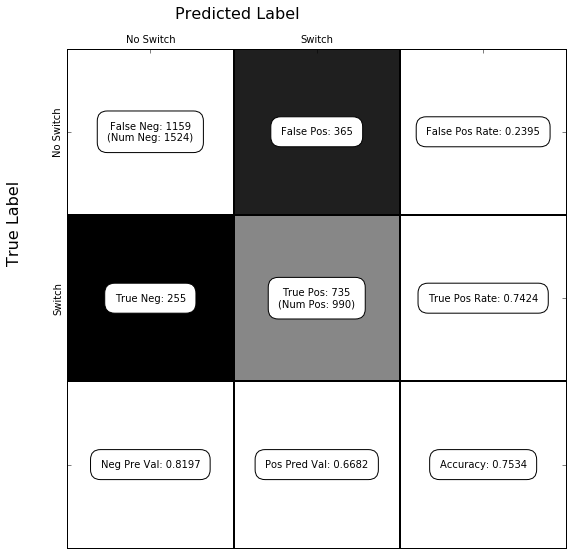

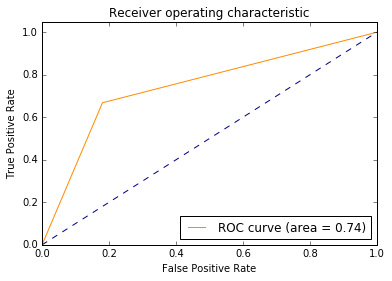

predictor : [value] [bootstrap mean, bootstrap std, (bootstrap confidence interval, confidence)]
arsenic :  [2.3529892161975106] [2.2647154137735233, 0.22302626345981225, (1.8575158179672389, 2.704466307646911, 0.95)]
distance :  [-1.3172417836715613] [-1.1181759365703519, 0.17888528635568232, (-1.4408343188500932, -0.7704636262452074, 0.95)]
y :  [0.3208996454779309] [0.41679806127333724, 0.1479392076894317, (0.12320512647803776, 0.698181912638999, 0.95)]
unsafe01 :  [1.8977969274180873] [1.9214480548528776, 0.10250740755287843, (1.711537607700458, 2.1223010689210353, 0.95)]
education_0 :  [-1.918387125563055] [-2.0704902595382193, 0.11397284447671158, (-2.3018359745813806, -1.8476414683045532, 0.95)]
education_2 :  [-1.8757320184215065] [-1.9647676852734344, 0.2669790094296356, (-2.518115014408101, -1.456244799396451, 0.95)]
education_3 :  [-2.0386456047843793] [-1.9204169464490122, 0.18045922711318196, (-2.278655593300075, -1.570881188381843, 0.95)]
education_4 :  [-1.95052241056973

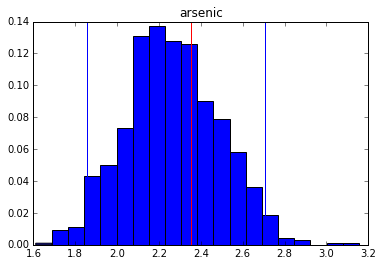

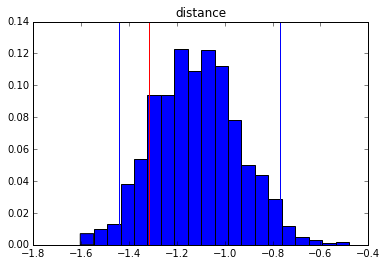

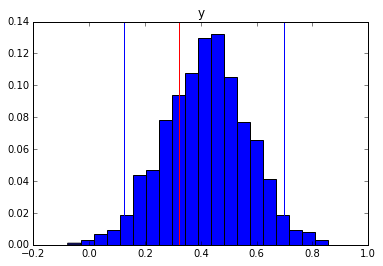

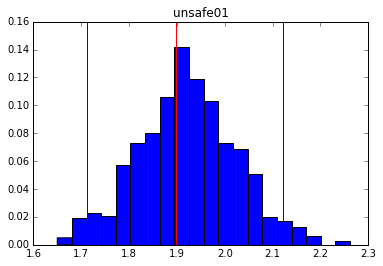

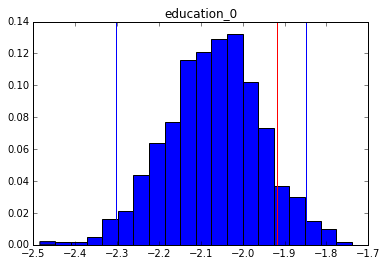

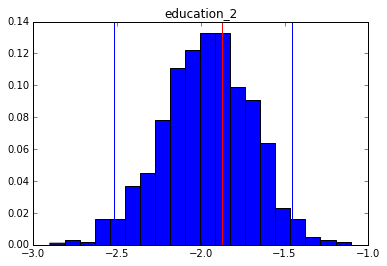

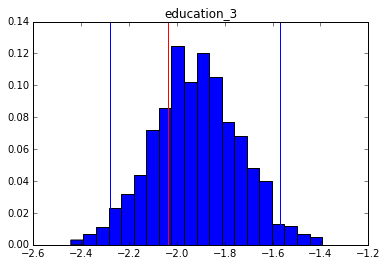

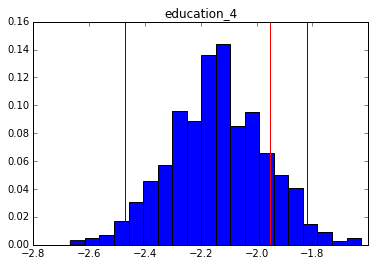

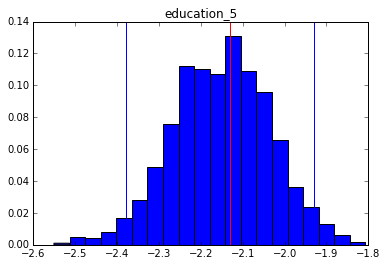

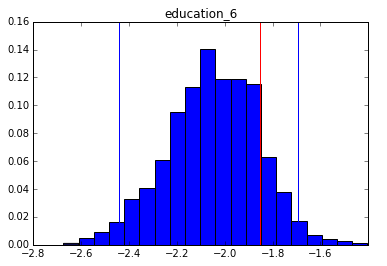

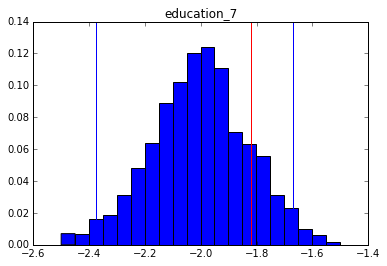

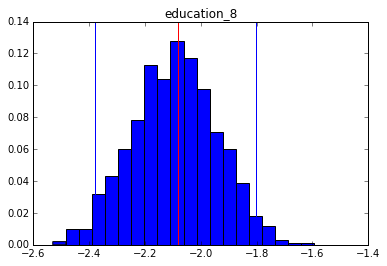

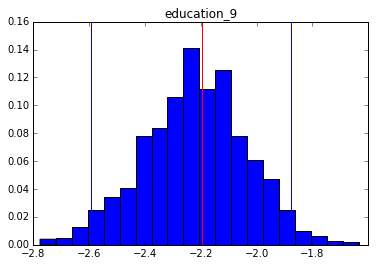

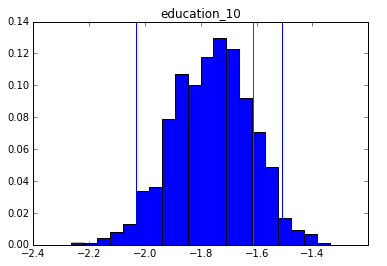

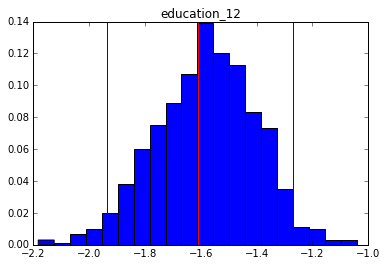

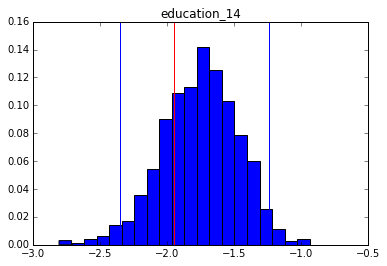

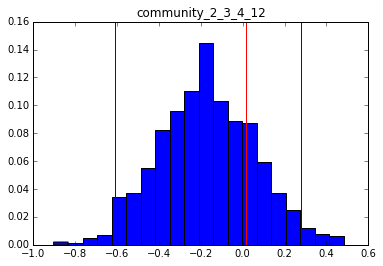

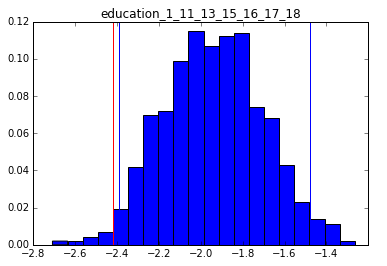

In [20]:
# train a model and visualize the result for analysis
# the predictors are the combinations found by backward_model_selection
model0,accuracy0 = prediction_and_display(predictors, df_train, df_test, True)

# show the uncertainty
model_params=bootstrap(df, predictors, 'switch', 1)
coefficients=bootstrap(df, predictors, 'switch', 1000)
uncertainty(model_params, coefficients, 0.95)


**The best combination found by backward model selection should be **

**['arsenic', 'distance', 'y', 'unsafe01', 'education_0', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'education_7', 'education_8', 'education_9', 'education_10', 'education_12', 'education_14', 'community_2_3_4_12', 'education_1_11_13_15_16_17_18']**

**SUMMARY of analysis of the current model:**

**arsenic has very strong positive relationship with switch**

**distance has strong negative relationship with switch**

**y has strong positive relationship with switch**

**unsafe has very strong positive relationship with switch**

**we may not conclude that community_2_3_4_12 has a positive relationship with switch. **

**we may not conclude that all existing education_* predictors have a relationship with switch, there are no evidence showing the coefficients are different from 0. **


**the accuracy is around 0.75, the misclassification error is around 0.25**

**type I error and type II error can be calculated from the shown confusion matrix, about 0.1 and 0.15**

**the roc curve shows that our model better than random guess line as it is closer to left-upper point, and the area under curve is about 0.74**

**As shown in the histograms for uncertainty of the predictors, most of the red line(parameter sample of a trained model) sits rather close to the center (or mean) of the distribution and most of the red line are in the interval shown by two blue lines(0.95 confidence interval). Together with the fact that the confidence interval is not too big, the current model should be stablefor most of the predictors. **
**However, for predictor 'education_1_11_13_15_16_17_18', the model may not be stable. **

#### remove some 'education_**' predictors, train a model, visualize the result again

['arsenic', 'distance', 'y', 'unsafe01', 'education_0', 'education_4', 'education_5', 'education_8', 'education_9']
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2437
Model:                          Logit   Df Residuals:                     2427
Method:                           MLE   Df Model:                            9
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                  0.2173
Time:                        18:08:39   Log-Likelihood:                -1283.1
converged:                       True   LL-Null:                       -1639.4
                                        LLR p-value:                1.348e-147
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.7826      0.175    -10.188      0.000      -2.125      -1.440
arsenic     

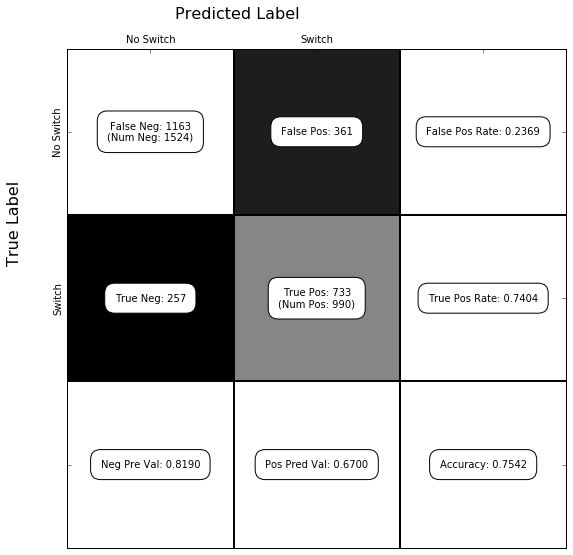

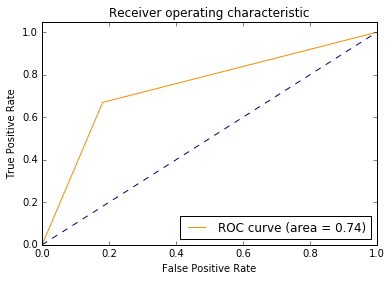

predictor : [value] [bootstrap mean, bootstrap std, (bootstrap confidence interval, confidence)]
arsenic :  [2.1962197774398047] [2.0908425614271704, 0.21676794745492306, (1.6971292351034857, 2.5232636878273214, 0.95)]
distance :  [-1.8408438641003295] [-1.7089620663084266, 0.18482475923067604, (-2.078779534174031, -1.3583565402167643, 0.95)]
y :  [-1.5407900646866637] [-1.6378101509385103, 0.08880780096178427, (-1.8107283864154156, -1.4590446658607734, 0.95)]
unsafe01 :  [1.5546431130648042] [1.6451873782029744, 0.09503961724998565, (1.4440637089832409, 1.835065406413814, 0.95)]
education_0 :  [-0.6779783950430295] [-0.6924327906284934, 0.07698212249766638, (-0.8503007623920676, -0.5557784630437659, 0.95)]
education_4 :  [-0.9200688791324004] [-0.7702053309711667, 0.13791668194602238, (-1.0445210782615033, -0.4979039848794861, 0.95)]
education_5 :  [-0.7582040743566992] [-0.7916137276840192, 0.07971622273260047, (-0.9551979095059813, -0.6388193043180574, 0.95)]
education_8 :  [-0.7732

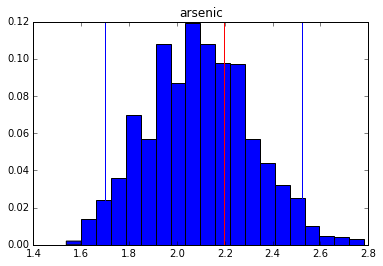

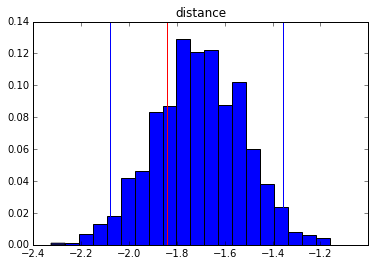

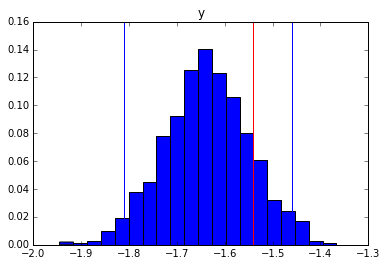

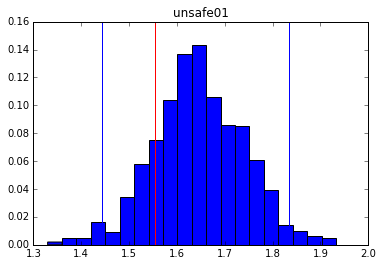

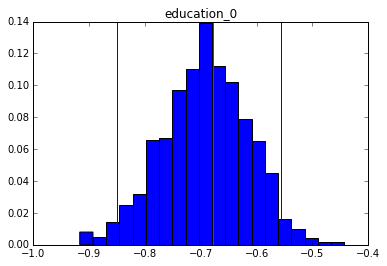

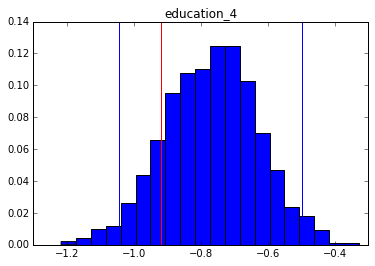

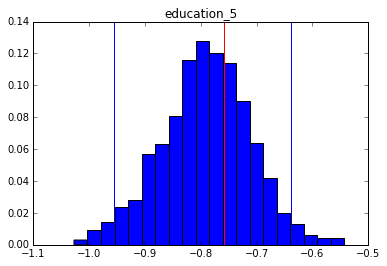

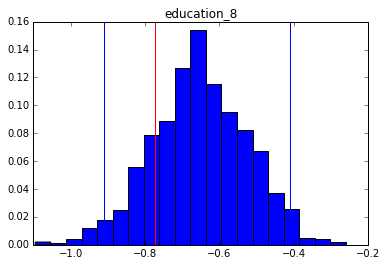

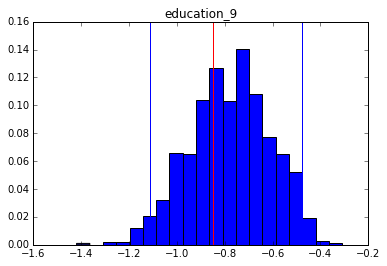

In [21]:
# from the z-values, p-values and graph above, we remove some of the education categories to see if there are any improvements
predictors.remove('education_14')
predictors.remove('education_1_11_13_15_16_17_18')
predictors.remove('education_3')
predictors.remove('education_12')
predictors.remove('education_10')
predictors.remove('education_2')
predictors.remove('community_2_3_4_12')
predictors.remove('education_7')
predictors.remove('education_6')

print(predictors)
model0,accuracy0 = prediction_and_display(predictors, df_train, df_test, True)

model_params=bootstrap(df, predictors, 'switch', 1)
coefficients=bootstrap(df, predictors, 'switch', 1000)
uncertainty(model_params, coefficients, 0.95)

**According to the p-values, z-values and graphs from the previous backward model selection function, we see that some dummy variables seem to be not significant. (for example, the p-values are so high to suggest that there is no evidence that the coefficients are different from 0)**

**Here we remove some dummy variables which start with 'education'. We did the removal one by one and decide which predictor to remove next by each result shown after each removal. And as shown in the code, we remove some dummy variables starting with 'education' and 'community'. **

**So as we can see from the accuracy, there seems to be no significant improvement by removing some education dummy variables.**

**SUMMARY of analysis of the current model:**

**arsenic has very strong positive relationship with switch**

**distance has strong negative relationship with switch**

**y has strong positive relationship with switch**

**unsafe has very strong positive relationship with switch**

**we may not conclude that all existing education_* predictors have a negative relationship with switch**


**the accuracy is around 0.75, the misclassification error is around 0.25**

**type I error and type II error can be calculated from the shown confusion matrix, about 0.1 and 0.15**

**the roc curve shows that our model better than random guess line as it is closer to left-upper point, and the area under curve is about 0.74**

**As shown in the histograms for uncertainty of the predictors, the red line(parameter sample of a trained model) sits rather close to the center (or mean) of the distribution and it is in the interval shown by two blue lines(0.95 confidence interval). Together with the fact that the confidence interval is not too big, the current model should be stable. **

#### some loocv

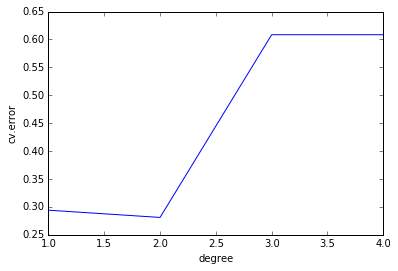

In [23]:

from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import LeaveOneOut
from sklearn.cross_validation import KFold
#from sklearn.cross_validation import Bootstrap
from sklearn.metrics import mean_squared_error
%matplotlib inline



auto_df = pd.read_csv("wells.csv", na_values="?")
auto_df.dropna(inplace=True)
auto_df.head()
auto_df['switch_true'] = auto_df['switch'].astype(int)

clf = LinearRegression()
loo = LeaveOneOut(len(auto_df))
X = auto_df[["arsenic"]].values
y = auto_df["switch_true"].values
n = np.shape(X)[0]
mses = []
for train, test in loo:
    Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    mses.append(mean_squared_error(ytest, ypred))
np.mean(mses)




def loo_shortcut(X, y):
    """ implement one-pass LOOCV calculation for linear models from ISLR Page 180 (Eqn 5.2) """
#     clf = LogisticRegression()
#     clf.fit(X, y)
    ypred = clf.predict(X)
    xbar = np.mean(X, axis=0)
    xsum = np.sum(np.power(X - xbar, 2))
    nrows = np.shape(X)[0]
    mses = []
    for row in range(0, nrows):
        hi = (1 / nrows) + (np.sum(X[row] - xbar) ** 2 / xsum)
        mse = (y[row] - ypred[row]) ** 2 / (1 - hi)
        mses.append(mse)
    return np.mean(mses)

loo_shortcut(auto_df[['arsenic']].values, auto_df["switch_true"].values)


# LOOCV against models of different degrees
auto_df["arsenic^2"] = auto_df["arsenic"] * auto_df["arsenic"]
auto_df["arsenic^3"] = auto_df["arsenic^2"] * auto_df["arsenic"]
auto_df["arsenic^4"] = auto_df["arsenic^3"] * auto_df["arsenic"]
auto_df["arsenic^5"] = auto_df["arsenic^4"] * auto_df["arsenic"]
auto_df["unit"] = 1
colnames = ["unit", "arsenic", "arsenic^2", "arsenic^3", "arsenic^4", "arsenic^5"]
cv_errors = []
for ncols in range(2, 6):
    X = auto_df[colnames[0:ncols]]
    y = auto_df["switch_true"]
    clf = LogisticRegression()
    clf.fit(X, y)
    cv_errors.append(loo_shortcut(X.values, y.values))
plt.plot(range(1,5), cv_errors)
plt.xlabel("degree")
plt.ylabel("cv.error")

**So from the loocv graph we can see that with only the arsenic predictor, the loocv error is the smallest with degree equal to 2, and the error greatly increase after degree increased to 3 or above. **

**This may suggest us that trying different degree of the predictors may lead to improvements in accuracy. However, as the loocv error of degree 2 is not significantlly smaller than the degree 1 for arsenic predictor, for predictor arsenic, trying out different degrees may not be useful. **

**We don't have time for further exploration on trying different degrees of predictors. But for future work on this, we will add different degrees of predictors as some new fearures to see if the accuracy has any improvement. If so, we may conclude that the switch values have stronger relationship with other degrees of predictors other than degree 1. **

## Conclusion

In the first section,

we treat all of the predictors as real-valued predictors and do some preprocessing (remove outliners and do normalization)

Then we show evaluate the performance and uncertainty of the model with all predictors. 

Then we do burteforce search for the best combinations of the predictors by k folds cross validation and evaluate its uncertainty. 

In the second section, 

We treat community and education as categorical predictors and do some preprocessing. (remove outliners, do normalization, merge some dummy variables with low counts together)

Then we use backward model selection to search for best combination of all current predictors by k folds cross validation and evaluate the performance and uncertainty of the model with the best combination. 

Then we try to remove some insignificant dummy predictors to improve the accuracy, which is not successful. 

At last, we try to use loocv to see what power of the predictor arsenic has the strongest relationship with switch. 

We have built a model with predicting accuracy around 0.75. (You can look for other performance data in details from content shown above)

We may conclude that

unsafe wells, amount of arsenic pollution and y have a strong positive relationship with switch. 

distance between the well from the nearest living area has strong negative relationship with switch. 

we may not conclude that there is an relationship between education , community and X with switch. 

### Future Work

(1) use loocv to explore different power of the predictors to add as new features to improve accuracy. 

(2) try different classification models instead of merely logistic regression.

(3) try forward model selection approach to see if there are any differences.

(4) explore more regularization to improve the accuracy. 